In [ ]:
import pandas as pd
from os.path import join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [4]:
raw_data_path = join("..", "data", "raw")
sample_100000_path = join(raw_data_path, "balanced_sample_100000.parquet")
sample_250000_path = join(raw_data_path, "balanced_sample_250000.parquet")

In [5]:
df = pd.read_parquet(sample_100000_path)
df = df.drop(columns=["TAIL_NUM", "FL_NUM"])

In [6]:
features = [
    "MONTH",  # num
    "DAY_OF_MONTH",  # num
    "DAY_OF_WEEK",  # num
    "UNIQUE_CARRIER",  # cat
    # "TAIL_NUM", #
    # "FL_NUM",  # cat
    "ORIGIN",  # cat
    "DEST",  # cat
    # celle-ci plutôt que DEP_TIME_BLK pour la comparer DEP_TIME
    "CRS_DEP_TIME",  # num
    "DEP_TIME",  # num
    # celle-ci pour avoir une plus grande finesse que DEP_DEL15
    "DEP_DELAY",  # num
    "TAXI_OUT",  # num
    "WHEELS_OFF",  # num
    "CRS_ARR_TIME",  # num
    "CRS_ELAPSED_TIME",  # num
    "DISTANCE",  # num
]
target = ["ARR_DEL15"]

In [7]:
cat_features = ["UNIQUE_CARRIER", "ORIGIN", "DEST"]
# cat_features = ["UNIQUE_CARRIER", "FL_NUM", "ORIGIN", "DEST"]
num_features = [feat for feat in features if feat not in cat_features]

In [8]:
X = df[features]
y = df[target]

In [9]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42
)

num_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

cat_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    [("num", num_pipeline, num_features), ("cat", cat_pipeline, cat_features)]
)

In [10]:
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")

In [ ]:
full_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", lr)])

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear", "saga"],
    "classifier__class_weight": ["balanced", None],
}

grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=0,
)

In [15]:
grid_search.fit(X_train, y_train.values.ravel())


print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score CV : {grid_search.best_score_:.4f}")

# Meilleurs paramètres : {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
# Meilleur score CV : 0.9118
# Meilleurs paramètres : {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
# Meilleur score CV : 0.9118
# Meilleurs paramètres : {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
# Meilleur score CV : 0.9118


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Meilleurs paramètres : {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Meilleur score CV : 0.9118


In [16]:
best_lr = grid_search.best_estimator_

y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)

In [17]:
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("-" * 60)
print("Évaluation du meilleur modèle")
print("-" * 60)
print(f"Précision : {lr_accuracy:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_lr))

------------------------------------------------------------
Évaluation du meilleur modèle
------------------------------------------------------------
Précision : 0.9162

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92     10078
         1.0       0.93      0.90      0.91      9922

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



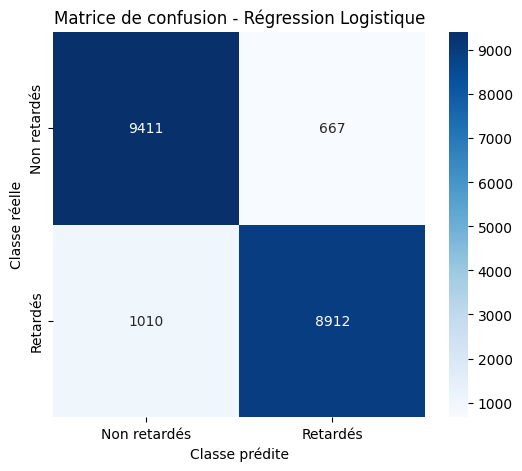

In [18]:
plt.figure(figsize=(6, 5))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non retardés", "Retardés"],
    yticklabels=["Non retardés", "Retardés"],
)
plt.title("Matrice de confusion - Régression Logistique")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

#### LightGBM


In [23]:
lgbm = lgb.LGBMClassifier(random_state=42)


In [27]:
full_pipeline_lgbm = Pipeline([("preprocessor", preprocessor), ("classifier", lgbm)])

param_grid_lgbm = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__num_leaves": [31, 50, 70],
    "classifier__objective": ["binary"],
    "classifier__metric": ["binary_logloss"],
}

grid_search_lgbm = GridSearchCV(
    full_pipeline_lgbm, param_grid_lgbm, cv=3, n_jobs=-1, verbose=0
)

In [28]:
grid_search_lgbm.fit(X_train, y_train.values.ravel())

[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Start training from score 0.003938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938
[LightGBM] [In

/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863
[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.240776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 374
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26718, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2677
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 372
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003863
[LightGBM] [Info] Start training from score 0.003863


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 26719, number of negative: 26615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 53334, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900


/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/

[LightGBM] [Info] Number of positive: 40078, number of negative: 39922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2792
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 424
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900
Meilleurs paramètres LightGBM : {'classifier__learning_rate': 0.1, 'classifier__metric': 'binary_logloss', 'classifier__n_estimators': 300, 'classifier__num_leaves': 31, 'classifier__objective': 'binary'}
Meilleur score CV LightGBM : 0.9110


In [29]:
print(f"Meilleurs paramètres LightGBM : {grid_search_lgbm.best_params_}")
print(f"Meilleur score CV LightGBM : {grid_search_lgbm.best_score_:.4f}")

Meilleurs paramètres LightGBM : {'classifier__learning_rate': 0.1, 'classifier__metric': 'binary_logloss', 'classifier__n_estimators': 300, 'classifier__num_leaves': 31, 'classifier__objective': 'binary'}
Meilleur score CV LightGBM : 0.9110


In [30]:
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)

print("-" * 60)
print("Évaluation du meilleur modèle LightGBM")
print("-" * 60)
print(f"Précision LightGBM : {lgbm_accuracy:.4f}")
print("\nRapport de classification LightGBM :")
print(classification_report(y_test, y_pred_lgbm))

------------------------------------------------------------
Évaluation du meilleur modèle LightGBM
------------------------------------------------------------
Précision LightGBM : 0.9139

Rapport de classification LightGBM :
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     10078
         1.0       0.93      0.89      0.91      9922

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


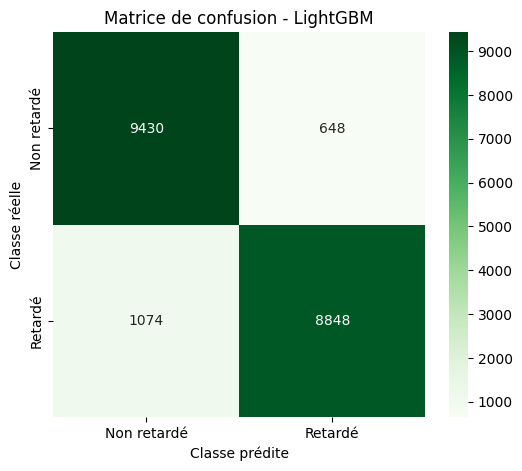

In [31]:
plt.figure(figsize=(6, 5))
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(
    cm_lgbm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Non retardé", "Retardé"],
    yticklabels=["Non retardé", "Retardé"],
)
plt.title("Matrice de confusion - LightGBM")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

#### Random Forest


In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rf = RandomForestClassifier(random_state=42)

In [34]:
full_pipeline_rf = Pipeline([("preprocessor", preprocessor), ("classifier", rf)])

# param_grid_rf = {
#     "classifier__n_estimators": [100, 200, 300],
#     "classifier__max_depth": [None, 10, 20, 30],
#     "classifier__min_samples_split": [2, 5, 10],
#     "classifier__min_samples_leaf": [1, 2, 4],
#     "classifier__class_weight": ["balanced", "balanced_subsample", None],
# }
param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__class_weight": ["balanced", None],
}

grid_search_rf = GridSearchCV(
    full_pipeline_rf,
    param_grid_rf,
    cv=3,
    n_jobs=-1,
    verbose=0,
)

In [35]:
grid_search_rf.fit(X_train, y_train.values.ravel())


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__class_weight': ['balanced', None], 'classifier__max_depth': [10, 20], 'classifier__min_samples_leaf': [1, 2], 'classifier__min_samples_split': [2, 5], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [36]:
print(f"Meilleurs paramètres Random Forest : {grid_search_rf.best_params_}")
print(f"Meilleur score CV Random Forest : {grid_search_rf.best_score_:.4f}")

Meilleurs paramètres Random Forest : {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Meilleur score CV Random Forest : 0.9018


In [37]:
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("-" * 60)
print("Évaluation du meilleur modèle Random Forest")
print("-" * 60)
print(f"Précision Random Forest : {rf_accuracy:.4f}")
print("\nRapport de classification Random Forest :")
print(classification_report(y_test, y_pred_rf))


------------------------------------------------------------
Évaluation du meilleur modèle Random Forest
------------------------------------------------------------
Précision Random Forest : 0.9055

Rapport de classification Random Forest :
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     10078
         1.0       0.92      0.88      0.90      9922

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



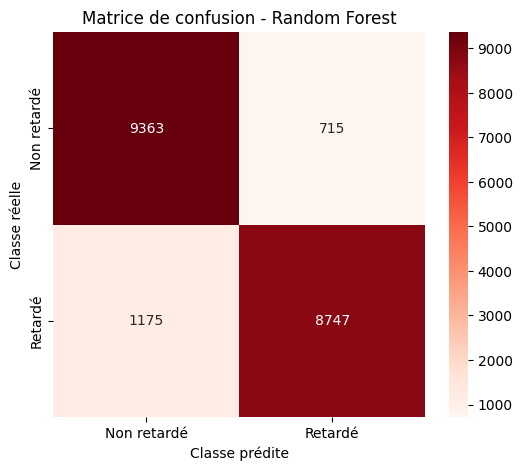

In [38]:
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Non retardé", "Retardé"],
    yticklabels=["Non retardé", "Retardé"],
)
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

#### Comparaison des meilleurs modèles

In [39]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)

**Régression logistique**

In [40]:
best_lr = grid_search.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_proba_lr[:, 1])

print("-" * 60)
print("Évaluation de la régression logistique")
print("-" * 60)
print(f"Précision : {lr_accuracy:.4f}")
print(f"Precision : {lr_precision:.4f}")
print(f"Recall : {lr_recall:.4f}")
print(f"F1-score : {lr_f1:.4f}")
print(f"AUC-ROC : {lr_auc:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_lr))

------------------------------------------------------------
Évaluation de la régression logistique
------------------------------------------------------------
Précision : 0.9162
Precision : 0.9304
Recall : 0.8982
F1-score : 0.9140
AUC-ROC : 0.9670

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92     10078
         1.0       0.93      0.90      0.91      9922

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



**LightGBM**

In [41]:
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)
y_proba_lgbm = best_lgbm.predict_proba(X_test)
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_precision = precision_score(y_test, y_pred_lgbm)
lgbm_recall = recall_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm)
lgbm_auc = roc_auc_score(y_test, y_proba_lgbm[:, 1])

print("-" * 60)
print("Évaluation de LightGBM")
print("-" * 60)
print(f"Précision : {lgbm_accuracy:.4f}")
print(f"Precision : {lgbm_precision:.4f}")
print(f"Recall : {lgbm_recall:.4f}")
print(f"F1-score : {lgbm_f1:.4f}")
print(f"AUC-ROC : {lgbm_auc:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_lgbm))

/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/marou/Formation/plane_delay_prediction/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


------------------------------------------------------------
Évaluation de LightGBM
------------------------------------------------------------
Précision : 0.9139
Precision : 0.9318
Recall : 0.8918
F1-score : 0.9113
AUC-ROC : 0.9700

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     10078
         1.0       0.93      0.89      0.91      9922

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



**Random Forest**

In [42]:
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_proba_rf[:, 1])

print("-" * 60)
print("Évaluation de Random Forest")
print("-" * 60)
print(f"Précision : {rf_accuracy:.4f}")
print(f"Precision : {rf_precision:.4f}")
print(f"Recall : {rf_recall:.4f}")
print(f"F1-score : {rf_f1:.4f}")
print(f"AUC-ROC : {rf_auc:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_rf))

------------------------------------------------------------
Évaluation de Random Forest
------------------------------------------------------------
Précision : 0.9055
Precision : 0.9244
Recall : 0.8816
F1-score : 0.9025
AUC-ROC : 0.9545

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     10078
         1.0       0.92      0.88      0.90      9922

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



In [44]:
print("-" * 70)
print("Tableau récapitulatif des scores des modèles")
print("-" * 70)
print(
    "{:<15} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "Modèle", "Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"
    )
)
print("-" * 70)
print(
    "{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        "Logistic Reg.", lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc
    )
)
print(
    "{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        "LightGBM", lgbm_accuracy, lgbm_precision, lgbm_recall, lgbm_f1, lgbm_auc
    )
)
print(
    "{:<15} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        "Random Forest", rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc
    )
)
print("-" * 70)

----------------------------------------------------------------------
Tableau récapitulatif des scores des modèles
----------------------------------------------------------------------
Modèle          Accuracy   Precision  Recall     F1-score   AUC-ROC   
----------------------------------------------------------------------
Logistic Reg.   0.9162     0.9304     0.8982     0.9140     0.9670    
LightGBM        0.9139     0.9318     0.8918     0.9113     0.9700    
Random Forest   0.9055     0.9244     0.8816     0.9025     0.9545    
----------------------------------------------------------------------


#### Conclusion

Bien que la régression logistique présente des performances légèrement supérieures en termes d'accuracy, de recall et de F1-score, LightGBM se distingue par une meilleure précision et un AUC-ROC plus élevé. Considérant que les écarts entre les deux modèles sont minimes sur les autres métriques, nous privilégions **LightGBM** en raison de sa capacité supérieure à discriminer les classes (meilleur AUC-ROC) et de son efficacité en termes de temps d'entraînement.